In [20]:
import ast
import inspect
import textwrap

def my_function(s):
    new_state = {}
    new_state["CTLA4"] = s["TCR"] and not s["Apoptosis"]
    new_state["PD1"] = s["CD28"] or s["IL2"] or s["PD1"]
    new_state["FOXP3"] = s["FOXP3"] and s["TGFb"]  # Notice: "FOXP3" appears in RHS
    return new_state

class DictKeyExtractor(ast.NodeVisitor):
    def __init__(self):
        self.target_key = None  # Store the LHS key
        self.source_keys = set()  # Store RHS keys

    def visit_Assign(self, node):
        """Visit an assignment statement."""
        # Extract left-hand side (LHS) key
        if isinstance(node.targets[0], ast.Subscript) and isinstance(node.targets[0].slice, ast.Constant):
            self.target_key = node.targets[0].slice.value

        # Visit RHS expression
        self.visit(node.value)

    def visit_Subscript(self, node):
        """Visit dictionary key accesses in RHS."""
        if isinstance(node.slice, ast.Constant):
            self.source_keys.add(node.slice.value)  # Add to RHS keys

def analyze_line(line):
    """Analyze a single line and return (line, target_key, source_keys)."""
    try:
        tree = ast.parse(line)  # Parse line
    except SyntaxError:
        return None  # Ignore invalid lines

    extractor = DictKeyExtractor()
    extractor.visit(tree)

    if extractor.target_key is not None:
        return (line.strip(), extractor.target_key, extractor.source_keys)
    return None

def extract_keys_line_by_line(func):
    """Extract dictionary keys from function line by line."""
    source = inspect.getsource(func)
    source = textwrap.dedent(source)  # Remove indentation
    lines = source.split("\n")  # Split function into lines

    results = []
    for line in lines:
        line = line.strip()  # Clean line
        if not line or line.startswith("#"):  # Skip empty/comment lines
            continue
        analysis = analyze_line(line)
        if analysis:
            results.append(analysis)

    return results

# Extract dictionary keys line by line
keys_by_line = extract_keys_line_by_line(my_function)

# Print results
print("\n=== Final Extracted Data ===")
for line, target_key, source_keys in keys_by_line:
    print(f"Line: {line}")
    print(f"Target Key: {target_key}")
    print(f"Source Keys: {source_keys}")
    print("-" * 30)



=== Final Extracted Data ===
Line: new_state["CTLA4"] = s["TCR"] and not s["Apoptosis"]
Target Key: CTLA4
Source Keys: {'TCR', 'Apoptosis'}
------------------------------
Line: new_state["PD1"] = s["CD28"] or s["IL2"] or s["PD1"]
Target Key: PD1
Source Keys: {'IL2', 'CD28', 'PD1'}
------------------------------
Line: new_state["FOXP3"] = s["FOXP3"] and s["TGFb"]  # Notice: "FOXP3" appears in RHS
Target Key: FOXP3
Source Keys: {'TGFb', 'FOXP3'}
------------------------------


In [21]:

class BooleanNetwork:

    def __init__(self):
        self.state = {}
        while True:
            try:
                self.update()
            except KeyError as e:
                missing_key = e.args[0]
                self.state[missing_key] = False
            else:
                break

    def update(self):
        new_state = self.state.copy()
        s = self.state  # Shortcut for readability

        new_state["CTLA4"] = s["TCR"] and not s["Apoptosis"]
        new_state["TCR"] = s["Stimuli"] and not (s["CTLA4"] or s["Apoptosis"])
        new_state["PDGFR"] = (s["S1P"] or s["PDGF"]) and not s["Apoptosis"]
        new_state["FYN"] = (s["TCR"] or s["IL2RB"]) and not s["Apoptosis"]
        new_state["Cytoskeleton_signaling"] = s["FYN"] and not s["Apoptosis"]
        new_state["LCK"] = (s["CD45"] or ((s["TCR"] or s["IL2RB"]) and not s["ZAP70"])) and not s["Apoptosis"]
        new_state["ZAP70"] = s["LCK"] and not (s["FYN"] or s["Apoptosis"])
        new_state["GRB2"] = (s["IL2RB"] or s["ZAP70"]) and not s["Apoptosis"]
        new_state["PLCG1"] = (s["GRB2"] or s["PDGFR"]) and not s["Apoptosis"]
        new_state["RAS"] = (s["GRB2"] or s["PLCG1"]) and not (s["GAP"] or s["Apoptosis"])
        new_state["GAP"] = (s["RAS"] or (s["PDGFR"] and s["GAP"])) and not (s["IL15"] or s["IL2"] or s["Apoptosis"])
        new_state["MEK"] = s["RAS"] and not s["Apoptosis"]
        new_state["ERK"] = (s["MEK"] and s["PI3K"]) and not s["Apoptosis"]
        new_state["PI3K"] = (s["PDGFR"] or s["RAS"]) and not s["Apoptosis"]
        new_state["NFKB"] = ((s["TPL2"] or s["PI3K"]) or (s["FLIP"] and s["TRADD"] and s["IAP"])) and not s["Apoptosis"]
        new_state["NFAT"] = s["PI3K"] and not s["Apoptosis"]
        new_state["RANTES"] = s["NFKB"] and not s["Apoptosis"]
        new_state["IL2"] = (s["NFKB"] or s["STAT3"] or s["NFAT"]) and not (s["TBET"] or s["Apoptosis"])
        new_state["IL2RBT"] = (s["ERK"] and s["TBET"]) and not s["Apoptosis"]
        new_state["IL2RB"] = (s["IL2RBT"] and (s["IL2"] or s["IL15"])) and not s["Apoptosis"]
        new_state["IL2RAT"] = (s["IL2"] and (s["STAT3"] or s["NFKB"])) and not s["Apoptosis"]
        new_state["IL2RA"] = (s["IL2"] and s["IL2RAT"]) and not (s["IL2RA"] or s["Apoptosis"])
        new_state["JAK"] = (s["IL2RA"] or s["IL2RB"] or s["RANTES"] or s["IFNG"]) and not (s["SOCS"] or s["CD45"] or s["Apoptosis"])
        new_state["SOCS"] = s["JAK"] and not (s["Apoptosis"] or s["IL2"] or s["IL15"])
        new_state["STAT3"] = s["JAK"] and not s["Apoptosis"]
        new_state["P27"] = s["STAT3"] and not s["Apoptosis"]
        new_state["Proliferation"] = s["STAT3"] and not (s["P27"] or s["Apoptosis"])
        new_state["TBET"] = (s["JAK"] or s["TBET"]) and not s["Apoptosis"]
        new_state["CREB"] = (s["ERK"] and s["IFNG"]) and not s["Apoptosis"]
        new_state["IFNGT"] = (s["TBET"] or s["STAT3"] or s["NFAT"]) and not s["Apoptosis"]
        new_state["IFNG"] = ((s["IL2"] or s["IL15"] or s["Stimuli"]) and s["IFNGT"]) and not (s["Apoptosis"] or s["SMAD"] or s["P2"])
        new_state["P2"] = (s["IFNG"] or s["P2"]) and not (s["Stimuli"] or s["Apoptosis"])
        new_state["GZMB"] = ((s["CREB"] and s["IFNG"]) or s["TBET"]) and not s["Apoptosis"]

        new_state["TPL2"] = (s["TAX"] or (s["PI3K"] and s["TNF"])) and not s["Apoptosis"]
        new_state["TNF"] = s["NFKB"] and not s["Apoptosis"]
        new_state["TRADD"] = s["TNF"] and not (s["IAP"] or s["A20"] or s["Apoptosis"])
        new_state["FasL"] = (s["STAT3"] or s["NFKB"] or s["NFAT"] or s["ERK"]) and not s["Apoptosis"]
        new_state["FasT"] = s["NFKB"] and not s["Apoptosis"]
        new_state["Fas"] = (s["FasT"] and s["FasL"]) and not (s["sFas"] or s["Apoptosis"])
        new_state["sFas"] = s["FasT"] and not s["Apoptosis"]
        new_state["Ceramide"] = s["Fas"] and not (s["S1P"] or s["Apoptosis"])
        new_state["DISC"] = (s["FasT"] and ((s["Fas"] and s["IL2"]) or s["Ceramide"] or (s["Fas"] and not s["FLIP"]))) and not s["Apoptosis"]

        new_state["Caspase"] = (((s["TRADD"] or s["GZMB"]) and s["BID"] and not s["IAP"]) or s["DISC"]) and not s["Apoptosis"]
        new_state["Apoptosis"] = s["Caspase"] or s["Apoptosis"]

        new_state["FLIP"] = (s["NFKB"] or (s["CREB"] and s["IFNG"])) and not (s["DISC"] or s["Apoptosis"])
        new_state["A20"] = s["NFKB"] and not s["Apoptosis"]
        new_state["BID"] = (s["Caspase"] or s["GZMB"]) and not (s["BclxL"] or s["MCL1"] or s["Apoptosis"])
        new_state["IAP"] = s["NFKB"] and not (s["BID"] or s["Apoptosis"])
        new_state["BclxL"] = (s["NFKB"] or s["STAT3"]) and not (s["BID"] or s["GZMB"] or s["DISC"] or s["Apoptosis"])
        new_state["MCL1"] = (s["IL2RB"] and s["STAT3"] and s["NFKB"] and s["PI3K"]) and not s["Apoptosis"]

        new_state["GPCR"] = s["S1P"] and not s["Apoptosis"]
        new_state["SMAD"] = s["GPCR"] and not s["Apoptosis"]
        new_state["SPHK1"] = s["PDGFR"] and not s["Apoptosis"]
        new_state["S1P"] = s["SPHK1"] and not (s["Ceramide"] or s["Apoptosis"])

    

        self.state = new_state

    def run(self, steps):
        for _ in range(steps):
            self.update()
            print(self.state)


Tasks
1. Using the provided code example, re-create the boolean network from Supp Table S4 of Zhang et al 2008. Try AI extraction, as a fall-back use lymphocyte.ipynb
2. visualize the network by extracting the target and source IDs from the code using the inspect and ast modules (see code example!) Place input nodes (outlinks only) at the top, and output nodes (inlinks only) at he bottom. Ignore out-links from the node "apoptosis" (for plotting smile


Input nodes: ['PDGF', 'IL15', 'CD45', 'TAX', 'Stimuli']
Output nodes: ['Proliferation', 'Cytoskeleton_signaling']
Total nodes: 59
Total edges: 193


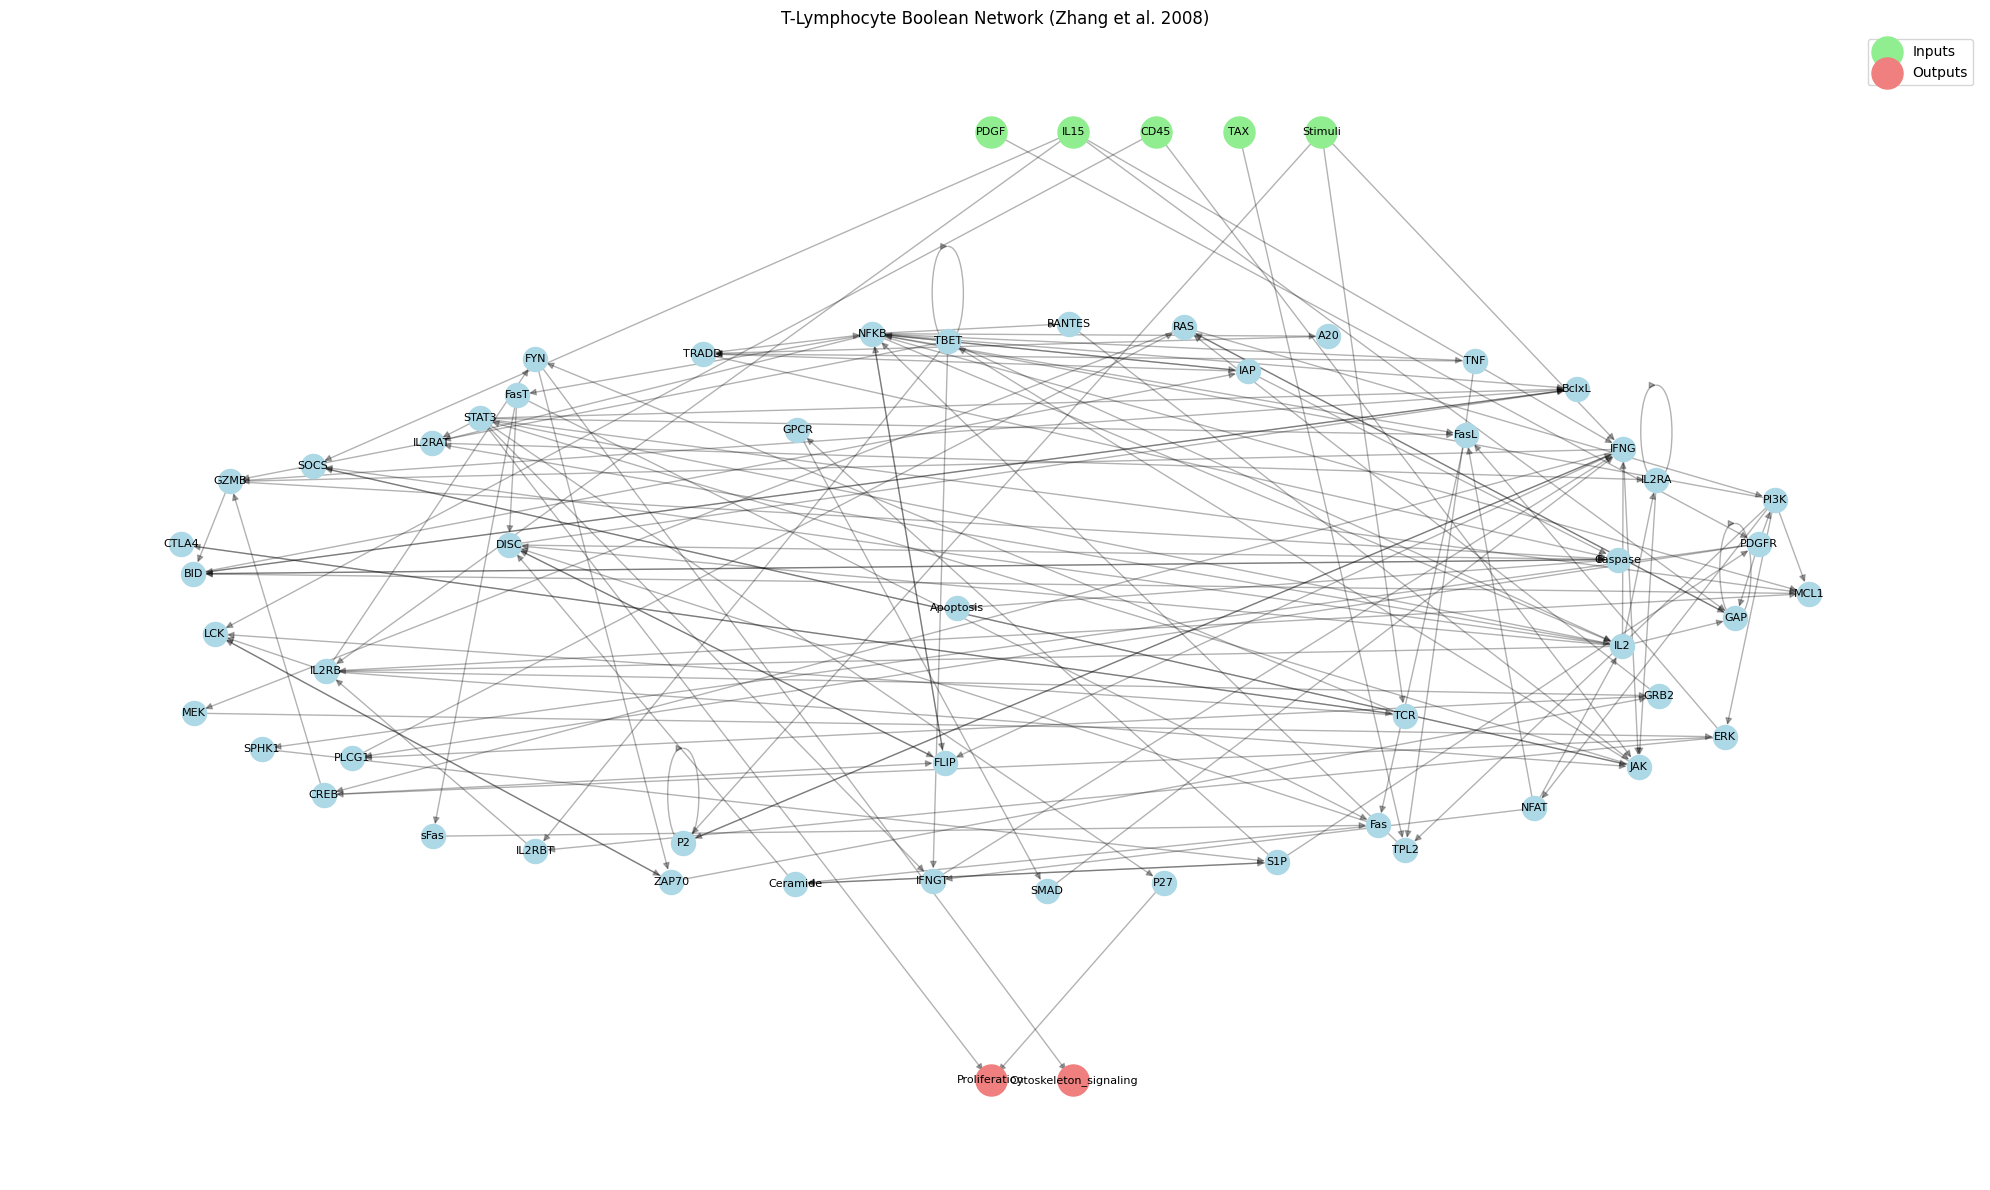

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# Extract the update method
def extract_network_structure(network_class):
    """Extract network edges from BooleanNetwork.update method"""
    import inspect
    import textwrap
    import ast
    
    # Get the update method source code
    update_method = network_class.update
    source = inspect.getsource(update_method)
    source = textwrap.dedent(source)
    lines = source.split("\n")
    
    edges = []
    
    for line in lines:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
            
        analysis = analyze_line(line)
        if analysis:
            line_text, target_key, source_keys = analysis
            # Create edges: source -> target
            for source_key in source_keys:
                #if source_key != target_key:  # Avoid self-loops for now
                edges.append((source_key, target_key))
    
    return edges

# Build the network graph
edges = extract_network_structure(BooleanNetwork)
G = nx.DiGraph()
G.add_edges_from(edges)

# Identify node types
all_nodes = set(G.nodes())

# Input nodes: only outgoing edges (no incoming)
input_nodes = [n for n in all_nodes if G.in_degree(n) == 0]

# Output nodes: only incoming edges (no outgoing), but exclude Apoptosis from outlinks
output_nodes = [n for n in all_nodes if G.out_degree(n) == 0]

# Middle nodes: everything else
middle_nodes = [n for n in all_nodes if n not in input_nodes and n not in output_nodes]

print(f"Input nodes: {input_nodes}")
print(f"Output nodes: {output_nodes}")
print(f"Total nodes: {len(all_nodes)}")
print(f"Total edges: {len(edges)}")

# Create a hierarchical layout
pos = {}

# Position input nodes at the top
for i, node in enumerate(input_nodes):
    pos[node] = (i * 2, 10)

# Position output nodes at the bottom
for i, node in enumerate(output_nodes):
    pos[node] = (i * 2, 0)

# Position middle nodes using a layout algorithm, then adjust y
middle_pos = nx.spring_layout(G.subgraph(middle_nodes), k=2, iterations=50)
for node, (x, y) in middle_pos.items():
    pos[node] = (x * 20, 5 + y * 3)  # Scale and center vertically

# Visualize
plt.figure(figsize=(20, 12))

# Draw nodes by type
nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, 
                       node_color='lightgreen', node_size=500, label='Inputs')
nx.draw_networkx_nodes(G, pos, nodelist=output_nodes, 
                       node_color='lightcoral', node_size=500, label='Outputs')
nx.draw_networkx_nodes(G, pos, nodelist=middle_nodes, 
                       node_color='lightblue', node_size=300)

# Draw edges (excluding those from Apoptosis as per task)
edges_to_draw = [(u, v) for u, v in G.edges() if u != 'Apoptosis']
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, 
                       alpha=0.3, arrows=True, arrowsize=10)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8)

plt.legend()
plt.title("T-Lymphocyte Boolean Network (Zhang et al. 2008)")
plt.axis('off')
plt.tight_layout()
plt.show()

3. Run parallel update of the network, and identify attractors and fixed points, for a few input settings (fixed combinations of input node states)


In [26]:
import copy

def run_scenario(input_states, max_steps=100):
    """
    Run network with specific input configuration
    
    Args:
        input_states: dict like {"Stimuli": True, "IL2": False}
        max_steps: maximum steps to run
    """
    # Initialize network
    network = BooleanNetwork()
    
    # Set input states (keep them fixed throughout)
    for node, value in input_states.items():
        network.state[node] = value
    
    # Track history
    history = [copy.deepcopy(network.state)]
    
    for step in range(max_steps):
        prev_state = copy.deepcopy(network.state)
        
        # Run one parallel update step
        network.update()
        
        # Re-apply input states (keep them constant)
        for node, value in input_states.items():
            network.state[node] = value
        
        history.append(copy.deepcopy(network.state))
        
        # Check for fixed point
        if network.state == prev_state:
            print(f"  Fixed point at step {step}")
            return network, history, "fixed_point", step
        
        # Check for cycle
        for i, past_state in enumerate(history[:-1]):
            if network.state == past_state:
                cycle_length = len(history) - 1 - i
                print(f"  Cycle detected! Length: {cycle_length}")
                return network, history, "cycle", cycle_length
    
    print(f"  No convergence after {max_steps} steps")
    return network, history, "no_convergence", max_steps
# Input nodes: ['PDGF', 'IL15', 'CD45', 'TAX', 'Stimuli']
# Test different scenarios
scenarios = {
    "Normal activation": {"Stimuli": True},
    "With IL2": {"Stimuli": True, "IL2": True},
    "With IL15": {"Stimuli": True, "IL15": True},
    "Viral (TAX)": {"Stimuli": True, "TAX": True},
    "With PDGF": {"Stimuli": True, "PDGF": True},
    "With CD45": {"Stimuli": True, "CD45": True},
    "No input": {},
}

results = {}
for name, inputs in scenarios.items():
    print(f"\n{'='*60}")
    print(f"SCENARIO: {name}")
    print(f"Inputs: {inputs}")
    print('='*60)
    
    network, history, result_type, info = run_scenario(inputs, max_steps=100)
    results[name] = (network, history, result_type, info)
    
    print(f"  Final state:")
    print(f"    Proliferation: {network.state['Proliferation']}")
    print(f"    Apoptosis: {network.state['Apoptosis']}")
    print(f"    IFNG: {network.state['IFNG']}")
    print(f"    IL2: {network.state['IL2']}")


SCENARIO: Normal activation
Inputs: {'Stimuli': True}
  Cycle detected! Length: 4
  Final state:
    Proliferation: False
    Apoptosis: False
    IFNG: False
    IL2: False

SCENARIO: With IL2
Inputs: {'Stimuli': True, 'IL2': True}
  Cycle detected! Length: 4
  Final state:
    Proliferation: False
    Apoptosis: False
    IFNG: False
    IL2: True

SCENARIO: With IL15
Inputs: {'Stimuli': True, 'IL15': True}
  Cycle detected! Length: 4
  Final state:
    Proliferation: False
    Apoptosis: False
    IFNG: False
    IL2: False

SCENARIO: Viral (TAX)
Inputs: {'Stimuli': True, 'TAX': True}
  Fixed point at step 8
  Final state:
    Proliferation: False
    Apoptosis: True
    IFNG: False
    IL2: False

SCENARIO: With PDGF
Inputs: {'Stimuli': True, 'PDGF': True}
  Fixed point at step 9
  Final state:
    Proliferation: False
    Apoptosis: True
    IFNG: False
    IL2: False

SCENARIO: With CD45
Inputs: {'Stimuli': True, 'CD45': True}
  Fixed point at step 12
  Final state:
    Prolifer

4. Run random stochastic update of the network for a few input settings. Establish time-averaged node activity and color-code it on the graph.
5. Analyze robustness of the graph and identify targets that could interfere with specific outputs like "proliferation".

In [27]:
import random
from collections import Counter
import numpy as np
import copy

def stochastic_update_step(state):
    """
    Pick one random node and update it.
    Keeps input nodes unchanged.
    """
    # Nodes that can be updated (exclude external inputs)
    updatable_nodes = [
        "CTLA4", "TCR", "PDGFR", "FYN", "Cytoskeleton_signaling", 
        "LCK", "ZAP70", "GRB2", "PLCG1", "RAS", "GAP", "MEK", "ERK",
        "PI3K", "NFKB", "NFAT", "RANTES", "IL2", "IL2RBT", "IL2RB",
        "IL2RAT", "IL2RA", "JAK", "SOCS", "STAT3", "P27", "Proliferation",
        "TBET", "CREB", "IFNGT", "IFNG", "P2", "GZMB", "TPL2", "TNF",
        "TRADD", "FasL", "FasT", "Fas", "sFas", "Ceramide", "DISC",
        "Caspase", "Apoptosis", "FLIP", "A20", "BID", "IAP", "BclxL",
        "MCL1", "GPCR", "SMAD", "SPHK1", "S1P"
    ]
    
    # Pick one random node
    node = random.choice(updatable_nodes)
    
    # Update rules (from BooleanNetwork.update method)
    s = state
    
    if node == "CTLA4":
        state[node] = s["TCR"] and not s["Apoptosis"]
    elif node == "TCR":
        state[node] = s["Stimuli"] and not (s["CTLA4"] or s["Apoptosis"])
    elif node == "PDGFR":
        state[node] = (s["S1P"] or s["PDGF"]) and not s["Apoptosis"]
    elif node == "FYN":
        state[node] = (s["TCR"] or s["IL2RB"]) and not s["Apoptosis"]
    elif node == "Cytoskeleton_signaling":
        state[node] = s["FYN"] and not s["Apoptosis"]
    elif node == "LCK":
        state[node] = (s["CD45"] or ((s["TCR"] or s["IL2RB"]) and not s["ZAP70"])) and not s["Apoptosis"]
    elif node == "ZAP70":
        state[node] = s["LCK"] and not (s["FYN"] or s["Apoptosis"])
    elif node == "GRB2":
        state[node] = (s["IL2RB"] or s["ZAP70"]) and not s["Apoptosis"]
    elif node == "PLCG1":
        state[node] = (s["GRB2"] or s["PDGFR"]) and not s["Apoptosis"]
    elif node == "RAS":
        state[node] = (s["GRB2"] or s["PLCG1"]) and not (s["GAP"] or s["Apoptosis"])
    elif node == "GAP":
        state[node] = (s["RAS"] or (s["PDGFR"] and s["GAP"])) and not (s["IL15"] or s["IL2"] or s["Apoptosis"])
    elif node == "MEK":
        state[node] = s["RAS"] and not s["Apoptosis"]
    elif node == "ERK":
        state[node] = (s["MEK"] and s["PI3K"]) and not s["Apoptosis"]
    elif node == "PI3K":
        state[node] = (s["PDGFR"] or s["RAS"]) and not s["Apoptosis"]
    elif node == "NFKB":
        state[node] = ((s["TPL2"] or s["PI3K"]) or (s["FLIP"] and s["TRADD"] and s["IAP"])) and not s["Apoptosis"]
    elif node == "NFAT":
        state[node] = s["PI3K"] and not s["Apoptosis"]
    elif node == "RANTES":
        state[node] = s["NFKB"] and not s["Apoptosis"]
    elif node == "IL2":
        state[node] = (s["NFKB"] or s["STAT3"] or s["NFAT"]) and not (s["TBET"] or s["Apoptosis"])
    elif node == "IL2RBT":
        state[node] = (s["ERK"] and s["TBET"]) and not s["Apoptosis"]
    elif node == "IL2RB":
        state[node] = (s["IL2RBT"] and (s["IL2"] or s["IL15"])) and not s["Apoptosis"]
    elif node == "IL2RAT":
        state[node] = (s["IL2"] and (s["STAT3"] or s["NFKB"])) and not s["Apoptosis"]
    elif node == "IL2RA":
        state[node] = (s["IL2"] and s["IL2RAT"]) and not (s["IL2RA"] or s["Apoptosis"])
    elif node == "JAK":
        state[node] = (s["IL2RA"] or s["IL2RB"] or s["RANTES"] or s["IFNG"]) and not (s["SOCS"] or s["CD45"] or s["Apoptosis"])
    elif node == "SOCS":
        state[node] = s["JAK"] and not (s["Apoptosis"] or s["IL2"] or s["IL15"])
    elif node == "STAT3":
        state[node] = s["JAK"] and not s["Apoptosis"]
    elif node == "P27":
        state[node] = s["STAT3"] and not s["Apoptosis"]
    elif node == "Proliferation":
        state[node] = s["STAT3"] and not (s["P27"] or s["Apoptosis"])
    elif node == "TBET":
        state[node] = (s["JAK"] or s["TBET"]) and not s["Apoptosis"]
    elif node == "CREB":
        state[node] = (s["ERK"] and s["IFNG"]) and not s["Apoptosis"]
    elif node == "IFNGT":
        state[node] = (s["TBET"] or s["STAT3"] or s["NFAT"]) and not s["Apoptosis"]
    elif node == "IFNG":
        state[node] = ((s["IL2"] or s["IL15"] or s["Stimuli"]) and s["IFNGT"]) and not (s["Apoptosis"] or s["SMAD"] or s["P2"])
    elif node == "P2":
        state[node] = (s["IFNG"] or s["P2"]) and not (s["Stimuli"] or s["Apoptosis"])
    elif node == "GZMB":
        state[node] = ((s["CREB"] and s["IFNG"]) or s["TBET"]) and not s["Apoptosis"]
    elif node == "TPL2":
        state[node] = (s["TAX"] or (s["PI3K"] and s["TNF"])) and not s["Apoptosis"]
    elif node == "TNF":
        state[node] = s["NFKB"] and not s["Apoptosis"]
    elif node == "TRADD":
        state[node] = s["TNF"] and not (s["IAP"] or s["A20"] or s["Apoptosis"])
    elif node == "FasL":
        state[node] = (s["STAT3"] or s["NFKB"] or s["NFAT"] or s["ERK"]) and not s["Apoptosis"]
    elif node == "FasT":
        state[node] = s["NFKB"] and not s["Apoptosis"]
    elif node == "Fas":
        state[node] = (s["FasT"] and s["FasL"]) and not (s["sFas"] or s["Apoptosis"])
    elif node == "sFas":
        state[node] = s["FasT"] and not s["Apoptosis"]
    elif node == "Ceramide":
        state[node] = s["Fas"] and not (s["S1P"] or s["Apoptosis"])
    elif node == "DISC":
        state[node] = (s["FasT"] and ((s["Fas"] and s["IL2"]) or s["Ceramide"] or (s["Fas"] and not s["FLIP"]))) and not s["Apoptosis"]
    elif node == "Caspase":
        state[node] = (((s["TRADD"] or s["GZMB"]) and s["BID"] and not s["IAP"]) or s["DISC"]) and not s["Apoptosis"]
    elif node == "Apoptosis":
        state[node] = s["Caspase"] or s["Apoptosis"]
    elif node == "FLIP":
        state[node] = (s["NFKB"] or (s["CREB"] and s["IFNG"])) and not (s["DISC"] or s["Apoptosis"])
    elif node == "A20":
        state[node] = s["NFKB"] and not s["Apoptosis"]
    elif node == "BID":
        state[node] = (s["Caspase"] or s["GZMB"]) and not (s["BclxL"] or s["MCL1"] or s["Apoptosis"])
    elif node == "IAP":
        state[node] = s["NFKB"] and not (s["BID"] or s["Apoptosis"])
    elif node == "BclxL":
        state[node] = (s["NFKB"] or s["STAT3"]) and not (s["BID"] or s["GZMB"] or s["DISC"] or s["Apoptosis"])
    elif node == "MCL1":
        state[node] = (s["IL2RB"] and s["STAT3"] and s["NFKB"] and s["PI3K"]) and not s["Apoptosis"]
    elif node == "GPCR":
        state[node] = s["S1P"] and not s["Apoptosis"]
    elif node == "SMAD":
        state[node] = s["GPCR"] and not s["Apoptosis"]
    elif node == "SPHK1":
        state[node] = s["PDGFR"] and not s["Apoptosis"]
    elif node == "S1P":
        state[node] = s["SPHK1"] and not (s["Ceramide"] or s["Apoptosis"])
    
    return state


def run_stochastic(input_states, num_steps=10000, burn_in=1000):
    """
    Run stochastic updates and calculate time-averaged activity
    
    Args:
        input_states: dict of fixed input values
        num_steps: number of random update steps
        burn_in: number of initial steps to discard (let system equilibrate)
    """
    
    # Initialize
    network = BooleanNetwork()
    
    # Set inputs (keep these fixed throughout)
    for node, value in input_states.items():
        network.state[node] = value
    
    # Burn-in period (let system equilibrate)
    for _ in range(burn_in):
        network.state = stochastic_update_step(network.state)
        # Keep inputs fixed
        for node, value in input_states.items():
            network.state[node] = value
    
    # Track activity (how often each node is True)
    activity_counter = Counter()
    
    # Run stochastic updates and count
    for step in range(num_steps):
        # Update one random node
        network.state = stochastic_update_step(network.state)
        
        # Keep inputs fixed
        for node, value in input_states.items():
            network.state[node] = value
        
        # Count which nodes are active
        for node, value in network.state.items():
            if value:
                activity_counter[node] += 1
    
    # Calculate time-averaged activity (fraction of time each node is True)
    time_avg_activity = {
        node: activity_counter.get(node, 0) / num_steps 
        for node in network.state.keys()
    }
    
    return time_avg_activity

def run_multiple_stochastic_trials(input_states, num_trials=10, num_steps=10000, burn_in=1000):
    """
    Run multiple stochastic trials and compute average activity across trials
    
    Args:
        input_states: dict of fixed input values
        num_trials: number of independent trials to run
        num_steps: number of update steps per trial
        burn_in: number of initial steps to discard per trial
    
    Returns:
        dict with mean and std of activity for each node
    """
    all_trials = []
    
    for trial in range(num_trials):
        activity = run_stochastic(input_states, num_steps=num_steps, burn_in=burn_in)
        all_trials.append(activity)
    
    # Get all node names
    all_nodes = all_trials[0].keys()
    
    # Calculate mean and std across trials
    mean_activity = {}
    std_activity = {}
    
    for node in all_nodes:
        activities = [trial[node] for trial in all_trials]
        mean_activity[node] = np.mean(activities)
        std_activity[node] = np.std(activities)
    
    return mean_activity, std_activity

# Run stochastic updates for all scenarios with multiple trials
print("="*80)
print("TASK 4: STOCHASTIC UPDATES - TIME-AVERAGED ACTIVITY (10 TRIALS)")
print("="*80)

stochastic_results = {}

for name, inputs in scenarios.items():
    print(f"\n{'='*80}")
    print(f"SCENARIO: {name}")
    print(f"Inputs: {inputs}")
    print('='*80)
    
    # Run 10 stochastic trials
    mean_activity, std_activity = run_multiple_stochastic_trials(
        inputs, 
        num_trials=10, 
        num_steps=10000, 
        burn_in=1000
    )
    
    stochastic_results[name] = {
        'mean': mean_activity,
        'std': std_activity
    }
    
    # Show most active nodes
    print("\nTop active nodes (mean activity > 0.01):")
    sorted_activity = sorted(mean_activity.items(), key=lambda x: x[1], reverse=True)
    for node, mean_val in sorted_activity:
        if mean_val > 0.01:  # Show nodes active >1% of time
            std_val = std_activity[node]
            print(f"  {node:25s}: {mean_val:.3f} ± {std_val:.3f}")
    
    # Show key outcome nodes
    print("\nKey outcomes (mean ± std):")
    print(f"  Proliferation: {mean_activity['Proliferation']:.3f} ± {std_activity['Proliferation']:.3f}")
    print(f"  Apoptosis:     {mean_activity['Apoptosis']:.3f} ± {std_activity['Apoptosis']:.3f}")
    print(f"  IFNG:          {mean_activity['IFNG']:.3f} ± {std_activity['IFNG']:.3f}")
    print(f"  IL2:           {mean_activity['IL2']:.3f} ± {std_activity['IL2']:.3f}")

# Summary comparison across scenarios
print(f"\n{'='*80}")
print("SUMMARY: KEY OUTCOMES ACROSS ALL SCENARIOS")
print('='*80)
print(f"{'Scenario':<25s} {'Proliferation':>15s} {'Apoptosis':>15s} {'IFNG':>15s} {'IL2':>15s}")
print("-"*80)

for name in scenarios.keys():
    mean = stochastic_results[name]['mean']
    std = stochastic_results[name]['std']
    
    print(f"{name:<25s} "
          f"{mean['Proliferation']:>6.3f}±{std['Proliferation']:<6.3f} "
          f"{mean['Apoptosis']:>6.3f}±{std['Apoptosis']:<6.3f} "
          f"{mean['IFNG']:>6.3f}±{std['IFNG']:<6.3f} "
          f"{mean['IL2']:>6.3f}±{std['IL2']:<6.3f}")

TASK 4: STOCHASTIC UPDATES - TIME-AVERAGED ACTIVITY (10 TRIALS)

SCENARIO: Normal activation
Inputs: {'Stimuli': True}

Top active nodes (mean activity > 0.01):
  Stimuli                  : 1.000 ± 0.000
  Apoptosis                : 0.843 ± 0.245
  FYN                      : 0.092 ± 0.139
  Cytoskeleton_signaling   : 0.091 ± 0.141
  CTLA4                    : 0.083 ± 0.123
  TCR                      : 0.080 ± 0.119
  LCK                      : 0.068 ± 0.098
  FasL                     : 0.033 ± 0.020
  IFNGT                    : 0.025 ± 0.018
  PLCG1                    : 0.024 ± 0.022
  IFNG                     : 0.023 ± 0.018
  NFKB                     : 0.022 ± 0.014
  TNF                      : 0.022 ± 0.016
  GRB2                     : 0.021 ± 0.016
  A20                      : 0.020 ± 0.013
  FLIP                     : 0.020 ± 0.015
  IAP                      : 0.020 ± 0.012
  TBET                     : 0.018 ± 0.011
  RANTES                   : 0.018 ± 0.010
  ZAP70               